# Recipe1M+ Model

In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *
import os
import json
import pandas as pd

Toggle this `model` switch between 1 and 2 to use different methods for generating the ingredients list.

- 1 :: filter using a common ingredients list
- 2 :: filter using a blacklist

In [2]:
model = 1

In [3]:
path = Path()
path.ls()

(#19) [Path('vocab_v4.txt'),Path('.Rhistory'),Path('salad.jpeg'),Path('training_images.txt'),Path('valid_images.txt'),Path('v3.pkl'),Path('layer1_sample.json'),Path('.ipynb_checkpoints'),Path('r1m_v2.ipynb'),Path('blacklist.txt')...]

## Getting the data

The notebook is set up to download the sample of the data we used automatically. In order to speed up the data wrangling process, we have provided the files necessary to get started together with this notebook. Ensure you upload the following files to the current directory, or wherever `path` is pointing to:

- training_images.txt :: list of training set image filenames in the sample
- valid_images.txt :: list of validation set image filenames in the sample
- layer1_sample.json :: json data containing recipe id, instructions, ingredients, and train-val-test partition
- layer2_sample.json :: json data containing recipe id, associated images, and urls for the images
- ingredients_simplified_Recipes5k.txt:: list of common ingredients, curated by the creators of the Recipes5k dataset
- blacklist.txt :: list of words to filter out of ingredients text

However, you can download more of the Recipe1M+ dataset [here](http://pic2recipe.csail.mit.edu/) if you would like to use other subsets or the entire dataset! Our project consisted of downloading the zip files:

- Layers (381 MiB)
- training (94 GiB)

If you would like the plain ingredients taken from the dataset, download:

- Ingredient detections (102 MiB)

## Cleaning the data

Get the training and validation set from files:

In [4]:
train_imgs = []
with open(path/'training_images.txt') as f:
    for line in f:
        train_imgs.append(line.strip())

valid_imgs = []
with open(path/'valid_images.txt') as f:
    for line in f:
        valid_imgs.append(line.strip())

# Ensure valid is about 20% of data
len(valid_imgs) / (len(valid_imgs) + len(train_imgs))
len(train_imgs) + len(valid_imgs)

29983

Create dictionaries for each layer to easily store the data:

In [5]:
# Function to return the pathname of each image associated with an a food id
def get_image_paths(datum, id):
    return [layer1[id]['partition'] + "/" +         # get the partition for the food id
            img['id'][0] + "/" +                    # get the first four characters of the image name
            img['id'][1] + "/" +
            img['id'][2] + "/" +
            img['id'][3] + "/" +
            img['id'] for img in datum['images']]   # do this for each image associated with a food id

# Create dictionary for layer1, with the key being 'id' and the value being the JSON object
layer1 = {}
with open(path/'layer1_sample.json') as f:
    for line in f:
        if len(line) < 10: continue
        datum = json.loads(line.strip().rstrip(','))
        layer1[datum['id']] = datum

# Create dictionary for layer2, with the key being 'id' and the values being the image paths associated with that id
layer2 = {}
with open(path/'layer2_sample.json') as f:
    for line in f:
        if len(line) < 10: continue
        datum = json.loads(line.strip().rstrip(','))                  # grab the line and strip the whitespace and comma at the end of it
        id = datum['id']
        if layer1[id]['partition'] == 'train':                        # get only the training set
            for image in datum['images']:
                layer2[image['id']] = {'id': id, 
                                       'ingredients': layer1[id]['ingredients'],
                                       'train': False if image['id'] in valid_imgs else True}


## Model 1

Build the ingredients list and the common vocabulary to use across training and validation images:

In [6]:
if model == 1:
    # Read in common ingredients list
    ingredients = []
    with open(path/'ingredients_simplified_Recipes5k.txt') as f:
        for line in f:
            ingredients.append(line.strip().split(','))

    # Build ingredients set (removes duplicate ingredients)
    ingredients_set = set([word for array in ingredients
                            for word in array])
    
    """
    For even more variation:
        Uncomment below lines for to remove least common ingredients from the ingredients list
    """
#     # Get counts of each ingredient
#     ingredients_array = [word for array in ingredients
#                         for word in array]

#     # Get 500 least common ingredients that show up in common ingredients list
#     least_common = [word[0] for word in Counter(ingredients_array).most_common()[-500:-1]]
#     ingredients_set.difference_update(set(least_common))


    # Get the ingredients from the data
    train_ingredients_not_cleaned = []
    train_ingredients = []
    for img in layer2:
        if layer2[img]['train']:
            train_ingredients_not_cleaned.append(layer2[img]['ingredients'])
    for t in train_ingredients_not_cleaned:
        for line in t:
            for word in line['text'].split():
                train_ingredients.append(word)

    # Get only the ingredients that appear in both the training set and the common ingredients list
    train_vocab = set([word for word in train_ingredients if word in ingredients_set])

## Model 2

Create the list of words to filter from ingredients text:

In [7]:
if model == 2:
    def readBlacklist(file):
        blacklist = []
        with open(file, 'r') as file:
            for line in file:
                line = line.rstrip('\n').strip().lower()
                blacklist.append(line)
        return blacklist

    blacklist = readBlacklist(path/'blacklist.txt')
    
    # Build the ingredients list
    ingredients = [[word for word in t['text'].lower().split() if (word.isalpha() and word not in blacklist)] 
    for datum in layer2
    for t in layer2[datum]['ingredients']]

    ingredients_array = []
    for array in ingredients:
        for ingredient in array:
            ingredients_array.append(ingredient)
    
    # Grab only words that appear more than 100 times, and filter out words 
    #  that end with 's' (to reduce duplicates with plurals)
    counter = Counter(ingredients_array)
    train_vocab = set([key for key in counter if counter[key] > 100 and not key.endswith('s')])

## Grab Labels from Test Image

In [8]:
"""
Grabs all ingredient text from a given recipe in layer 1 and filters it to the
valid ingredients.
"""
def get_labels(id):
    arrays = [[word.strip(',').lower() for word in t['text'].split() if word.strip(',').isalpha()]
                for t in layer1[id]['ingredients']]
    labels = [word for array in arrays 
                for word in array
                if word in train_vocab]
    return set(labels)

get_labels('00e1e8922e')

{'basil',
 'bay',
 'capers',
 'celery',
 'chicken',
 'cloves',
 'garlic',
 'macaroni',
 'oil',
 'olive',
 'onion',
 'parsley',
 'pepper',
 'sugar',
 'vinegar',
 'wine'}

## Setting up the `DataLoader`

Define functions for use in the `DataBlock`:

In [9]:
def get_x(r): 
    f = r['image']
    return (data_path/f[0]/f[1]/f[2]/f[3]/f)

def get_y(r): return r['labels']

def splitter(df):
    train = df.index[df['train']].tolist()
    valid = df.index[~df['train']].tolist()
    return train,valid

Create and display the `DataFrame` to store the necessary data:

In [10]:
df_data = {'image': [img for img in layer2],
           'labels': [get_labels(layer2[img]['id']) for img in layer2],
           'food id': [layer2[img]['id'] for img in layer2],
           'train': [layer2[img]['train'] for img in layer2]}
df = pd.DataFrame(df_data, columns = ['image', 'labels', 'food id', 'train'])

df.head()

,image,labels,food id,train
0,6bdca6e490.jpg,"{pepper, chicken, tea}",000075604a,True
1,fbb388415c.jpg,"{coconut, milk, wafer, stevia, vanilla, whipped, cream, ice}",00016355e6,True
2,03b8cd1303.jpg,"{cracker, raspberries, preserves, whipped, sugar, cream, cheese, butter, crust}",0006ef8deb,True
3,738ef0f88b.jpg,"{flour, onion, olive, cloves, oil, broth, butter, pepper, oregano, celery, garlic, pasta, chicken, basil}",00098bc4cc,True
4,a4ce7da6b2.jpg,"{orange, paprika, pepper, sugar, garlic, pork, barbecue}",00125c0174,True


In [11]:
dblock = DataBlock();
dsets = dblock.datasets(df)

Download the sample from the Recipe1M+ dataset:

In [12]:
data_path = untar_data('https://ds1.cs.calvin.edu/Data/recipe1M_sample_trainonly.tgz')
data_path

Path('/scratch/cs344/data/recipe1M_sample_trainonly')

In [13]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

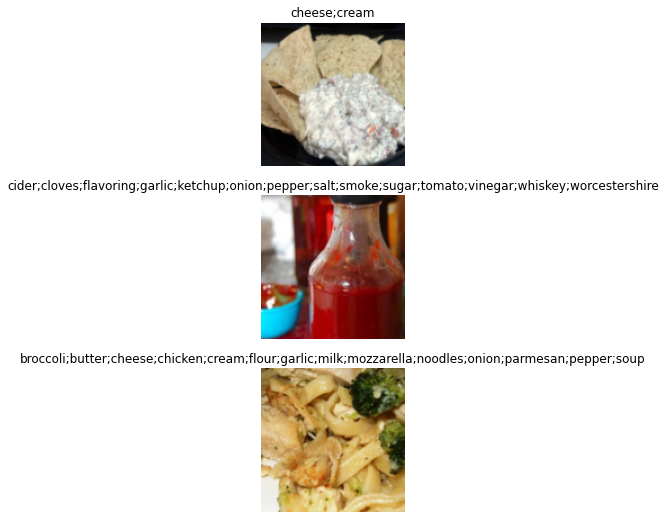

In [14]:
dls.show_batch(nrows=3, ncols=1)

In [15]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.4))
learn.fine_tune(3, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.078869,0.057778,0.983478,01:42


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.055930,0.053120,0.984027,01:43
1,0.052591,0.050801,0.984312,01:42
2,0.051294,0.050399,0.984365,01:43


Check for the threshold that maximizes accuracy:

In [16]:
preds,targs = learn.get_preds()
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9834)

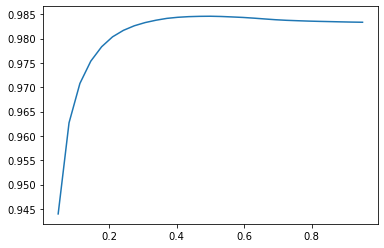

In [17]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

Test the model out on a training set image:

/scratch/cs344/data/recipe1M_sample_trainonly/0/3/b/8/03b8cd1303.jpg


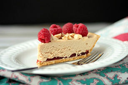

['baking',
 'butter',
 'cheese',
 'chocolate',
 'cream',
 'egg',
 'flour',
 'milk',
 'salt',
 'soda',
 'sugar',
 'vanilla',
 'whipped']

In [18]:
"""
Handles getting the model's predictions for a given image.
Displays the target image, gets the model's probabilities, and converts
them into the ingredients.
"""
def predict_ingredients(img_path):
    print(img_path)
    img = PILImage.create(img_path)
    display(img.to_thumb(128,128))
    preds = learn.predict(img)
    preds_list = preds[-1].tolist()
    pred_idxs = [preds_list.index(elem) for elem in preds_list if elem > 0.2]
    pred_list = []
    for idx in pred_idxs:
        pred_list.append(dls.vocab[idx])
    return pred_list
    
predict_ingredients(data_path/'0/3/b/8/03b8cd1303.jpg')